# Distributed and Batch-wise Training and Prediction with scikit-learn in Exasol

This example project provides an example for using batch-wise training and prediction with scikit-learn in Exasol. Batch-wise training and prediction allows you to train machine-learning models on data which is larger as the main memory limit of the UDFs. We'll use well known ["Adult income"](https://archive.ics.uci.edu/ml/datasets/adult) dataset which consist of data form the 1994 U.S. Census database. The dataset is designed to predict whether an adult person makes over 50K a year.

In the process, we demonstrate that there is no need to export data from Exasol to a different computer or server in order to examine or transform the data. Furthermore, it also isn't necessary for training and testing machine learning models. Everything can be done using user-defined functions (UDFs) directly inside Exasol where the data is stored.

Because the focus of this example project is on how you can better use machine learning tools with Exasol, we will not discuss machine learning topics such as classifier selection and tuning in depth. Because there are many different machine learning methods, choosing a "good" one is highly dependent on the problem to be solved and the data available. Rather, we want to demonstrate how you can more effectively and efficiently use your models with your data in Exasol.

### Prerequisites

The intended audience of this article is assumed to have a basic understanding of the following.
* Machine learning methods
* Exasol, in particular user-defined functions (UDFs)
* Python programming, including
  * [Scikit-learn](https://scikit-learn.org/stable/)
  * [Pandas](https://pandas.pydata.org/)
  * [NumPy](http://www.numpy.org/)

The following resources might help to understand these topics:
  * Python Machine Learning - Second Edition, Sebastian Raschka, Vahid Mirjalili, September 2017
  * Learning scikit-learn: Machine Learning in Python, Raúl Garreta, Guillermo Moncecchi, November 2013
  * [EXASOL Manual](https://www.exasol.com/portal/display/DOC/User+Manual+6.1.0)
  * [Scikit Learn Ensemble](https://scikit-learn.org/stable/modules/ensemble.html)
  * [Scikit Learn Incremental Learning](https://scikit-learn.org/stable/computing/scaling_strategies.html?highlight=incremental%20learning#incremental-learning)
  
### Technical Notes and Recommendations

* The code in this Jupyter Notebook was tested using Python 3.6 and 3.7.
* We recommend that your Exasol instance have at least 6GB RAM.
* The code below uses HTTPS to access Exasol's BucketFS by default. If you prefer to use HTTP, please set `EXASOL_BUCKETFS_USE_HTTPS = False` (see [Exasol Setup](#Exasol-Setup)).

### Readability Tip

The UDF scripts below are defined in triple-quoted Python strings (e.g. `sql = textwrap.dedent(f"""...""")`), which prevent the Python syntax highlighting from working in the Jupyter Notebook. If you simply remove one of the quotation marks at the beginning of the string (i.e. `sql = textwrap.dedent(f""...""")`), the syntax highlighting will work which can greatly improve the code's readability. However, please don't forget to add the quotation mark back before executing the cell.

## Problem Description

### Data Description

## Setup

Here, we specify some basic information, which is used throughout this example. In particular, we specify the URL, user name, and password for the Exasol host(s) and EXABucket.

We also specify the scripting language to be used, which is the 'python3-ds-EXASOL-6.0.0' flavor (i.e. Python 3 with selected data science modules for Exasol 6.0), available in Exasol's script-languages GitHub repository. Pre-packaged releases are available in the release area of the Github repository. The 'python3-ds-*' flavors have the added benefit of integrated Pandas DataFrame support for loading data from Exasol into a script (i.e. ctx.get_dataframe()) and emitting data from a script (i.e. ctx.emit()). If you use newer version of the 'python3-ds-*' flavors (since commit 480d79a), you need to change in the EXASOL_UDF_CLIENT from 'exaudfclient' to 'exaudfclient_py3', because since then, Exasol supports Python2 and Python3 UDFs in the same container.

### Install Python Dependencies

In [1]:
!pip install pyexasol stopwatch.py git+https://github.com/exasol/data-science-utils-python.git@develop

  Cloning https://github.com/exasol/data-science-utils-python.git (to revision develop) to /tmp/pip-req-build-99_jlgbw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for stopwatch.py: filename=stopwatch.py-1.0.1-py3-none-any.whl size=3057 sha256=4ce98732378004e0ea88b9754ec444bbbba12a539376269f550014345c50c1cc
  Stored in directory: /home/jupyter/.cache/pip/wheels/02/c0/e2/daa5bb3a96e7339241088a02b39f508ccdf0896e01cac02ee2
Successfully built stopwatch.py


### Create connection to the DB

In [3]:
EXASOL_DSN="localhost:8888"
EXASOL_USER="sys"
EXASOL_PASSWORD="exasol" 
EXASOL_SCHEMA="ML_TEST"

def connect():
    import pyexasol
    c = pyexasol.connect(dsn=EXASOL_DSN, user=EXASOL_USER, password=EXASOL_PASSWORD)
    c.execute("ALTER SESSION SET SCRIPT_LANGUAGES='PYTHON3=builtin_python3 PYTHON3_DS=localzmq+protobuf:///bfsdefault/default/container/python3-ds-EXASOL-6.1.0-release-current?lang=python#buckets/bfsdefault/default/container/python3-ds-EXASOL-6.1.0-release-current/exaudf/exaudfclient_py3';")
    c.execute(f"CREATE SCHEMA IF NOT EXISTS {EXASOL_SCHEMA};")
    c.open_schema(EXASOL_SCHEMA)
    return c;

c=connect()
c.execute("select 1").fetchall()

[(1,)]

### Import Dataset
- First, we load the Dataset from a CSV directly into the database
- We use here the well known adult dataset. 
    - The task of the dataset is to predict whether the income exceeds $50K/yr based on census data.

In [ ]:
!wget "https://datahub.io/machine-learning/adult/r/1.csv"

In [15]:
c=connect()
from stopwatch import Stopwatch
import pandas as pd
c.execute("""
CREATE OR REPLACE TABLE adult (
  age integer,
  workclass varchar(2000000),
  fnlwgt integer,	
  education varchar(2000000),
  education_num integer,	
  marital_status varchar(2000000),
  occupation varchar(2000000),
  relationship varchar(2000000),
  race varchar(2000000),
  sex varchar(2000000),
  capitalgain integer,	
  capitalloss integer,	
  hoursperweek integer,
  native_country varchar(2000000),
  class varchar(2000000)
);
""")
df = pd.read_csv("1.csv")
c.import_from_pandas(df,"adult")

## Inspect the Dataset

### Sample

In [23]:
c=connect()
c.export_to_pandas("select * from adult limit 10")

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITALGAIN,CAPITALLOSS,HOURSPERWEEK,NATIVE_COUNTRY,CLASS
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K
5,2,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,2,United-States,<=50K
6,3,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,0,Jamaica,<=50K
7,3,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,2,United-States,>50K
8,1,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,4,0,3,United-States,>50K
9,2,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,2,0,2,United-States,>50K


### Table Statistics

In [25]:
c=connect()
with open("column_statistics_script.sql") as f:
    sql_script=f.read()
    c.execute(sql_script)
c.execute(f"execute script table_stats('{EXASOL_SCHEMA}', 'ADULT', '{EXASOL_SCHEMA}', 'ADULT_TABLE_STATS', false);")
c.export_to_pandas(f"select * from adult_table_stats")

,ID,COLUMN_SCHEMA,COLUMN_TABLE,COLUMN_NAME,COLUMN_ORDINAL_POSITION,COLUMN_TYPE,SQL_EXPRESSION_DESCRIPTION,SQL_EXPRESSION_RESULT
0,1,ML_TEST,ADULT,NaN,0,NaN,the number of records in the source table,48842
1,2,ML_TEST,ADULT,AGE,1,"DECIMAL(18,0)",the number of null values,0
2,3,ML_TEST,ADULT,AGE,1,"DECIMAL(18,0)",the number of distinct values,5
3,4,ML_TEST,ADULT,AGE,1,"DECIMAL(18,0)",the minimum value,0
4,5,ML_TEST,ADULT,AGE,1,"DECIMAL(18,0)",the value of the 0.25 percentile,1
...,...,...,...,...,...,...,...,...
86,87,ML_TEST,ADULT,NATIVE_COUNTRY,14,VARCHAR(2000000) UTF8,the number of most occurences,43832
87,88,ML_TEST,ADULT,CLASS,15,VARCHAR(2000000) UTF8,the number of null values,0
88,89,ML_TEST,ADULT,CLASS,15,VARCHAR(2000000) UTF8,the number of distinct values,2
89,90,ML_TEST,ADULT,CLASS,15,VARCHAR(2000000) UTF8,the value(s) with the most occurences,<=50K


### Class/Target (Income) distribution

<AxesSubplot:>

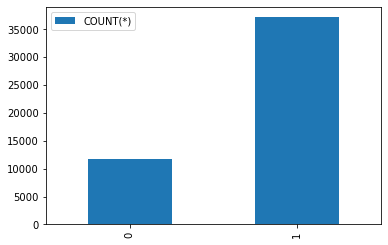

In [27]:
c=connect()
c.export_to_pandas("select class, count(*) from adult group by class").plot.bar()

### Work class distribution

In [31]:
c=connect()
c.export_to_pandas("select workclass, count(*) from adult group by workclass")

,WORKCLASS,COUNT(*)
0,Without-pay,21
1,State-gov,1981
2,NaN,2799
3,Self-emp-not-inc,3862
4,Never-worked,10
5,Local-gov,3136
6,Self-emp-inc,1695
7,Federal-gov,1432
8,Private,33906


<AxesSubplot:>

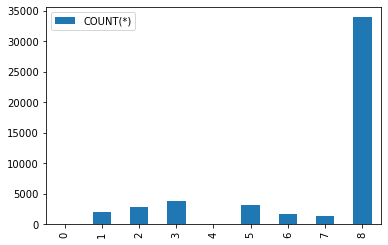

In [32]:
c.export_to_pandas("select workclass, count(*) from adult group by workclass").plot.bar()

### Two column statistics

In [30]:
c=connect()
c.export_to_pandas("""
    select workclass, class, count(*) 
    from adult group by workclass, class 
    order by workclass, class
    """)

,WORKCLASS,CLASS,COUNT(*)
0,Federal-gov,<=50K,871
1,Federal-gov,>50K,561
2,Local-gov,<=50K,2209
3,Local-gov,>50K,927
4,Never-worked,<=50K,10
5,Private,<=50K,26519
6,Private,>50K,7387
7,Self-emp-inc,<=50K,757
8,Self-emp-inc,>50K,938
9,Self-emp-not-inc,<=50K,2785


## Preprocess the Dataset in the Database
We need to normalize the data before we can use it in scikit-learn. For that we do the following operations in the database to benfit from its speed and scalebility.
- Id generation for categorical columns
- Normalization of numerical columns

Both operations need compute functions on the whole dataset and can get slow for large datasets with the usual data-science libraries.

**Disclaimer**: For the sake of simplicity we left out the split in trainings and test set. However, it is now problem for the database to split the dataset randomly, similar how we randomize the order.

In [33]:
c=connect()
import textwrap
c.execute("""
CREATE OR REPLACE TABLE adult_with_id AS 
SELECT 
  rownum as id,
  AGE, WORKCLASS, FNLWGT, EDUCATION, EDUCATION_NUM, MARITAL_STATUS, OCCUPATION, 
  RELATIONSHIP, RACE, SEX, CAPITALGAIN, CAPITALLOSS, HOURSPERWEEK, NATIVE_COUNTRY, CLASS
FROM adult;
""")
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE WORKCLASS_CATEGORIES AS SELECT rownum - 1 AS id, WORKCLASS 
FROM (SELECT DISTINCT WORKCLASS FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE EDUCATION_CATEGORIES AS SELECT rownum - 1 AS id, EDUCATION
FROM (SELECT DISTINCT EDUCATION FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE MARITAL_STATUS_CATEGORIES AS SELECT rownum - 1 AS id, MARITAL_STATUS 
FROM (SELECT DISTINCT MARITAL_STATUS FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE OCCUPATION_CATEGORIES AS SELECT rownum - 1 AS id, OCCUPATION 
FROM (SELECT DISTINCT OCCUPATION FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE RELATIONSHIP_CATEGORIES AS SELECT rownum - 1 AS id, RELATIONSHIP 
FROM (SELECT DISTINCT RELATIONSHIP FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE RACE_CATEGORIES AS SELECT rownum - 1 AS id, RACE 
FROM (SELECT DISTINCT RACE FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE SEX_CATEGORIES AS SELECT rownum - 1 AS id, SEX 
FROM (SELECT DISTINCT SEX FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE NATIVE_COUNTRY_CATEGORIES AS SELECT rownum - 1 AS id, NATIVE_COUNTRY 
FROM (SELECT DISTINCT NATIVE_COUNTRY FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE CLASS_CATEGORIES AS SELECT rownum - 1 AS id, CLASS 
FROM (SELECT DISTINCT CLASS FROM adult_with_id);
"""))
c.execute(textwrap.dedent("""
CREATE OR REPLACE TABLE adult_preprocessed AS 
SELECT
  adult.id,
  1.00 * ("AGE" - MIN("AGE") OVER()) / (MAX("AGE") OVER () - MIN("AGE") OVER ()) AS "AGE", 
  1.00 * ("FNLWGT" - MIN("FNLWGT") OVER()) / (MAX("FNLWGT") OVER () - MIN("FNLWGT") OVER ()) AS "FNLWGT", 
  1.00 * ("EDUCATION_NUM" - MIN("EDUCATION_NUM") OVER()) / (MAX("EDUCATION_NUM") OVER () - MIN("EDUCATION_NUM") OVER ()) AS "EDUCATION_NUM", 
  1.00 * ("CAPITALGAIN" - MIN("CAPITALGAIN") OVER()) / (MAX("CAPITALGAIN") OVER () - MIN("CAPITALGAIN") OVER ()) AS "CAPITALGAIN", 
  1.00 * ("CAPITALLOSS" - MIN("CAPITALLOSS") OVER()) / (MAX("CAPITALLOSS") OVER () - MIN("CAPITALLOSS") OVER ()) AS "CAPITALLOSS", 
  1.00 * ("HOURSPERWEEK" - MIN("HOURSPERWEEK") OVER()) / (MAX("HOURSPERWEEK") OVER () - MIN("HOURSPERWEEK") OVER ()) AS "HOURSPERWEEK", 
  WORKCLASS_CATEGORIES.id AS WORKCLASS, 
  EDUCATION_CATEGORIES.id AS EDUCATION, 
  MARITAL_STATUS_CATEGORIES.id AS MARITAL_STATUS, 
  OCCUPATION_CATEGORIES.id AS OCCUPATION, 
  RELATIONSHIP_CATEGORIES.id AS RELATIONSHIP, 
  RACE_CATEGORIES.id AS RACE, 
  SEX_CATEGORIES.id AS SEX, 
  NATIVE_COUNTRY_CATEGORIES.id AS NATIVE_COUNTRY, 
  CLASS_CATEGORIES.id AS CLASS 
FROM adult_with_id as adult
JOIN WORKCLASS_CATEGORIES ON adult.WORKCLASS = WORKCLASS_CATEGORIES.WORKCLASS 
JOIN EDUCATION_CATEGORIES ON adult.EDUCATION = EDUCATION_CATEGORIES.EDUCATION 
JOIN MARITAL_STATUS_CATEGORIES ON adult.MARITAL_STATUS = MARITAL_STATUS_CATEGORIES.MARITAL_STATUS 
JOIN OCCUPATION_CATEGORIES ON adult.OCCUPATION = OCCUPATION_CATEGORIES.OCCUPATION 
JOIN RELATIONSHIP_CATEGORIES ON adult.RELATIONSHIP = RELATIONSHIP_CATEGORIES.RELATIONSHIP 
JOIN RACE_CATEGORIES ON adult.RACE = RACE_CATEGORIES.RACE 
JOIN SEX_CATEGORIES ON adult.SEX = SEX_CATEGORIES.SEX 
JOIN NATIVE_COUNTRY_CATEGORIES ON adult.NATIVE_COUNTRY = NATIVE_COUNTRY_CATEGORIES.NATIVE_COUNTRY 
JOIN CLASS_CATEGORIES ON adult.CLASS = CLASS_CATEGORIES.CLASS
"""))
c.export_to_pandas("select * from adult_preprocessed limit 10")

,ID,AGE,FNLWGT,EDUCATION_NUM,CAPITALGAIN,CAPITALLOSS,HOURSPERWEEK,WORKCLASS,EDUCATION,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,NATIVE_COUNTRY,CLASS
0,143,0.00,0.205413,0.600000,0,0.00,0.25,8,13,4,9,4,2,1,18,1
1,145,1.00,0.062214,0.600000,0,0.00,0.50,8,13,4,8,0,2,1,29,1
2,147,0.00,0.109609,0.600000,0,0.00,0.25,8,13,6,9,2,2,1,29,1
3,149,1.00,0.113575,0.400000,0,0.75,0.50,8,11,6,0,2,2,1,29,1
4,154,0.00,0.191390,0.533333,0,0.00,0.25,8,4,4,0,4,2,1,29,1
5,156,0.75,0.117965,0.533333,0,0.00,0.75,8,4,6,0,2,2,1,29,1
6,157,0.00,0.136129,0.800000,0,0.00,0.50,8,14,4,4,3,2,1,29,1
7,158,1.00,0.325498,0.600000,0,0.50,0.00,3,13,3,11,5,3,1,29,1
8,159,0.25,0.120551,0.533333,0,0.00,0.75,8,4,1,0,3,2,1,29,1
9,160,0.50,0.145550,0.800000,0,0.00,0.75,8,14,3,9,0,3,1,29,1


### Correlation Matrix

In [181]:
c=connect()
with open("correlation_matrix_script.sql") as f:
    sql_script=f.read()
    c.execute(sql_script)
c.execute("""
    CREATE OR REPLACE VIEW ADULT_NUMERICAL AS 
    select age, fnlwgt, education_num, capitalgain, capitalloss , hoursperweek, class from adult_preprocessed
    """)
c.execute(f"execute script corr_matrix('{EXASOL_SCHEMA}', 'ADULT_NUMERICAL', '{EXASOL_SCHEMA}', 'ADULT_CORR', 20, false);")
c.export_to_pandas(f"select * from ADULT_CORR")

ExaQueryError: 
(
    message     =>  "data exception - invalid character value for cast; Value: '<=50K'" caught in script "ML_TEST"."CORR_MATRIX" at line 133 (Session: 1692033752662147072)
    dsn         =>  localhost:8888
    user        =>  sys
    schema      =>  ML_TEST
    session_id  =>  1692033752662147072
    code        =>  43000
    query       =>  execute script corr_matrix('ML_TEST', 'ADULT_NUMERICAL', 'ML_TEST', 'ADULT_CORR', 20, false)
)


## Create Training UDFs

### Computing the number of categories for categorical columns

In [162]:
c=connect()

categories = \
    c.export_to_pandas("""
        select 
            count(distinct workclass),
            count(distinct education), 
            count(distinct marital_status), 
            count(distinct occupation), 
            count(distinct relationship), 
            count(distinct race), 
            count(distinct sex), 
            count(distinct native_country)
        from adult_with_id
        """).values[0]+1
categories=categories.tolist()
print(categories)

[9, 17, 8, 15, 7, 6, 3, 42]


## Run batch-wise training

We use the linear SGDClassifier from scikit-learnas model, because it allows the batch-wise learning for large datasets and use the database to randomize the order.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


In [170]:
c=connect()
sql="""
CREATE OR REPLACE PYTHON3_DS SET SCRIPT train_sgd_classifier(
                pos float, id int,
                age float, fnlwgt float, education_num float, capitalgain float, capitalloss float, hoursperweek float, 
                workclass int, education int, marital_status int, occupation int, relationship int, race int, sex int, native_country int, 
                class int) 
EMITS (bucketfs_path varchar(10000)) AS
from sklearn.linear_model import SGDClassifier
from exasol_data_science_utils_python.model_utils.partial_fit_iterator import PartialFitIterator
from exasol_data_science_utils_python.model_utils.iteratorconfig import IteratorConfig
from exasol_bucketfs_utils_python import upload, download
from exasol_bucketfs_utils_python.bucketfs_config import BucketFsConfig, BucketFSCredentials


def run(ctx):
    classifier = SGDClassifier()
    iterator_config = IteratorConfig(
        categorical_input_column_names=["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"],
        numerical_input_column_names=["age", "fnlwgt", "education_num", "capitalgain", "capitalloss", "hoursperweek"],
        target_column_name="class",
        input_column_category_counts=%s,
        target_classes=2,
    )
    iterator = PartialFitIterator(
        iterator_config=iterator_config,
        classifier=classifier
    )
    epochs = 10
    for i in range(epochs):
        iterator.train(ctx, batch_size=100)
    
    bucketfs_credentials = BucketFSCredentials(host="localhost", port="6583", user="w", pwd="write")
    bucketfs_config = BucketFsConfig(credentials=bucketfs_credentials,
                                     bucket="default",
                                     bucketfs_name="bfsdefault",
                                     is_https=False)

    file_name=f"{str(exa.meta.session_id)}_{str(exa.meta.statement_id)}_{str(exa.meta.node_id)}_{str(exa.meta.vm_id)}.pkl"
    upload.upload_object_to_bucketfs_via_joblib(
            object=iterator,
            bucketfs_config=bucketfs_config,
            bucket_file_path=file_name)
    ctx.emit(file_name)
/
"""%str(categories)
#print(sql)
c.execute(textwrap.dedent(sql))

c=connect()
c.execute(textwrap.dedent("""
CREATE OR REPLACE PYTHON3_DS SET SCRIPT merge_sgd_classifier(bucketfs_path varchar(100000)) 
EMITS (bucketfs_path varchar(10000)) AS
from exasol_data_science_utils_python.model_utils.partial_fit_iterator import PartialFitIterator
from exasol_bucketfs_utils_python.bucketfs_config import BucketFsConfig, BucketFSCredentials
from exasol_bucketfs_utils_python import upload, download

def run(ctx):
    bucketfs_credentials = BucketFSCredentials(host="localhost", port="6583", user="w", pwd="write")
    bucketfs_config = BucketFsConfig(credentials=bucketfs_credentials,
                                     bucket="default",
                                     bucketfs_name="bfsdefault",
                                     is_https=False)

    df = ctx.get_dataframe()
    partial_fit_iterators=[]
    for i,s in df.iterrows():
        bucketfs_path = s["bucketfs_path"]
        partial_fit_iterator = \
            download.download_object_from_bucketfs_via_joblib(
                None,
                bucketfs_config=bucketfs_config,
                file_name=bucketfs_path
            )
        partial_fit_iterators.append(partial_fit_iterator)
    voting_iterator = PartialFitIterator.combine_to_voting_classifier(partial_fit_iterators)
    
    file_name=f"{str(exa.meta.session_id)}_{str(exa.meta.statement_id)}_{str(exa.meta.node_id)}_{str(exa.meta.vm_id)}.pkl"
    upload.upload_object_to_bucketfs_via_joblib(
            object=voting_iterator,
            bucketfs_config=bucketfs_config,
            bucket_file_path=file_name)
    ctx.emit(file_name)

/
"""))

<ExaStatement session_id=1692033184325435392 stmt_idx=3>

## Run Training

In [171]:
c=connect()
r=c.execute("""
select merge_sgd_classifier(train.bucketfs_path)
from (

    select train_sgd_classifier(
                    pos, id,
                    age, fnlwgt, education_num, capitalgain, capitalloss, hoursperweek, 
                    workclass, education, marital_status, occupation, relationship, race, sex, native_country, class)
    from (
    
      select floor(rand(1,4)) as group_, rand(0,1) as pos, -- randomize the order and the partiton of the training data
             id, age, fnlwgt, education_num, capitalgain, capitalloss, hoursperweek, 
             workclass, education, marital_status, occupation, relationship, race, sex, native_country, class
      from adult_preprocessed
    ) as q
    group by group_
    
) train
""")
base_path=r.fetchall()[0][0]
print(base_path)

1692033186702491648_6_0_140056606826816.pkl


## Create Prediction UDFs

In [172]:
c.execute(textwrap.dedent(f"""
CREATE OR REPLACE PYTHON3_DS SET SCRIPT predict_sgd_classifier(
                base_path varchar(20000), id int, 
                age float, fnlwgt float, education_num float, capitalgain float, capitalloss float, hoursperweek float, 
                workclass int, education int, marital_status int, occupation int, relationship int, race int, sex int, native_country int, 
                class int) 
EMITS (id int, predicted_class int) AS
from sklearn.linear_model import SGDClassifier
from exasol_data_science_utils_python.model_utils.partial_fit_iterator import PartialFitIterator
from exasol_data_science_utils_python.model_utils.iteratorconfig import IteratorConfig
from exasol_bucketfs_utils_python.bucketfs_config import BucketFsConfig, BucketFSCredentials
from exasol_bucketfs_utils_python import upload, download

def init(ctx):
    bucketfs_credentials = BucketFSCredentials(host="localhost", port="6583", user="w", pwd="write")
    bucketfs_config = BucketFsConfig(credentials=bucketfs_credentials,
                                     bucket="default",
                                     bucketfs_name="bfsdefault",
                                     is_https=False)
    bucketfs_path = ctx.base_path
    votingt_iterator = \
        download.download_object_from_bucketfs_via_joblib(
            None,
            bucketfs_config=bucketfs_config,
            file_name=bucketfs_path
        )
    return votingt_iterator

def run(ctx):
    votingt_iterator = init(ctx)
    votingt_iterator.predict(ctx, 1000, lambda result: ctx.emit(result[["id","predicted_result"]]))
    

/
"""))

<ExaStatement session_id=1692033186702491648 stmt_idx=4>

## Run parallel prediction
We run the prediction in parallel in multiple instances of our UDFs. This allows us to parallelize algorithms for prediction which usually don't provide functionallity for parallel execution. To achieve this, you only need to add a `group by` clause to the query. 

In [174]:
c=connect()


sql=f"""
create or replace table prediction_results as
select adult_with_id.id, age, fnlwgt, education_num, capitalgain, capitalloss, hoursperweek, 
       workclass, education, marital_status, occupation, relationship, race, sex, native_country,
       adult_with_id.class, CLASS_CATEGORIES.class as predicted_class
from (
        select predict_sgd_classifier(
                        '{base_path}', id, 
                        age, fnlwgt, education_num, capitalgain, capitalloss, hoursperweek, 
                        workclass, education, marital_status, occupation, relationship, race, sex, native_country, 
                        class)
        from adult_preprocessed
        group by iproc(), mod(rownum,3) -- parallelize prediction with 2 instances per node
    ) as prediction
join adult_with_id -- join source tables and resolve predicted categories
on prediction.id=adult_with_id.id
join CLASS_CATEGORIES
on prediction.predicted_class=CLASS_CATEGORIES.id
order by adult_with_id.id
"""
c.execute(sql)
c.export_to_pandas("select * from prediction_results limit 100")

,ID,AGE,FNLWGT,EDUCATION_NUM,CAPITALGAIN,CAPITALLOSS,HOURSPERWEEK,WORKCLASS,EDUCATION,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,NATIVE_COUNTRY,CLASS,PREDICTED_CLASS
0,4473,3,117502,9,0,0,2,Private,HS-grad,Married-civ-spouse,Adm-clerical,Wife,White,Female,United-States,<=50K,<=50K
1,4474,4,180401,6,0,0,2,Private,10th,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,>50K,<=50K
2,4475,3,146603,15,0,0,2,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K,>50K
3,4476,3,143822,14,0,0,2,State-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K,>50K
4,4477,0,51985,9,0,0,2,Private,HS-grad,Never-married,Craft-repair,Not-in-family,White,Male,United-States,<=50K,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4575,2,37019,9,0,0,3,Self-emp-inc,HS-grad,Never-married,Farming-fishing,Not-in-family,White,Male,United-States,<=50K,<=50K
96,4576,2,148015,13,4,0,2,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,United-States,>50K,>50K
97,4577,2,122975,9,0,0,1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,Trinadad&Tobago,<=50K,<=50K
98,4578,3,349795,13,0,0,2,State-gov,Bachelors,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,<=50K,>50K
